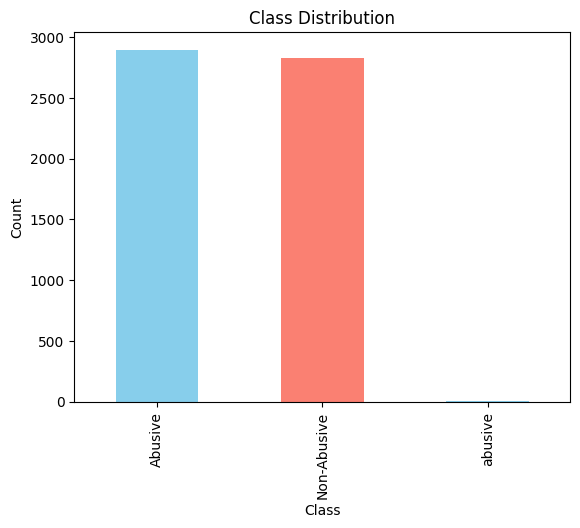

Training data saved to fasttext_train.txt
Validation data saved to fasttext_dev.txt


In [1]:
import pandas as pd
import re
import fasttext
import matplotlib.pyplot as plt

malayalam_train = pd.read_csv('AWM_train.csv')
tamil_train = pd.read_csv('AWT_train.csv')
malayalam_dev = pd.read_csv('AWM_dev.csv')
tamil_dev = pd.read_csv('AWT_dev.csv')

malayalam_train['language'] = 'malayalam'
tamil_train['language'] = 'tamil'
malayalam_dev['language'] = 'malayalam'
tamil_dev['language'] = 'tamil'

train_data = pd.concat([malayalam_train, tamil_train], ignore_index=True)
dev_data = pd.concat([malayalam_dev, tamil_dev], ignore_index=True)

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


train_data['Text'] = train_data['Text'].apply(preprocess_text)
dev_data['Text'] = dev_data['Text'].apply(preprocess_text)

train_data['Class'].value_counts().plot(kind='bar', title="Class Distribution", color=['skyblue', 'salmon'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

train_data['fasttext'] = train_data.apply(lambda row: f"__label__{row['Class']} {row['Text']}", axis=1)
dev_data['fasttext'] = dev_data.apply(lambda row: f"__label__{row['Class']} {row['Text']}", axis=1)

train_file = 'fasttext_train.txt'
dev_file = 'fasttext_dev.txt'
train_data['fasttext'].to_csv(train_file, index=False, header=False)
dev_data['fasttext'].to_csv(dev_file, index=False, header=False)

print(f"Training data saved to {train_file}")
print(f"Validation data saved to {dev_file}")


In [2]:
model = fasttext.train_supervised(
    input=train_file,
    lr=0.1,            
    epoch=50,  
    wordNgrams=2, 
    dim=300,       
    loss="softmax",     
    bucket=2000000
)

model.save_model("optimized_fasttext_model.bin")
print("Optimized FastText model trained and saved.")

result = model.test(dev_file)

print("Validation Results:")
print(f"Samples: {result[0]}")
print(f"Precision: {result[1]:.4f}")
print(f"Recall: {result[2]:.4f}")
print(f"F1 Score: {2 * result[1] * result[2] / (result[1] + result[2]):.4f}")

Optimized FastText model trained and saved.
Validation Results:
Samples: 1227
Precision: 0.7253
Recall: 0.7253
F1 Score: 0.7253


In [3]:
test_data = pd.read_csv('AWM_test_without_labels.csv')

test_data['Text'] = test_data['Text'].apply(preprocess_text)

test_data['predictions'] = [
    model.predict(text)[0][0].replace('__label__', '') for text in test_data['Text']
]

output_file = 'fasttext2M_test_results.csv'
test_data[['id','Text', 'predictions']].to_csv(
    output_file, 
    index=False, 
    header=False, 
    encoding='utf-8' 
)
print(f"Test predictions saved to {output_file}.")

Test predictions saved to fasttext2M_test_results.csv.


In [4]:
print(test_data.head(5))


   id                                               Text  predictions
0   1                   സരജ നനറ ആര ആണ ആള ഇറകക പടപപകകക ആണ  Non-Abusive
1   2  എതര അലകക വളപപചചല നനകക അർഹത ഇലലതതത അർഹത ഇലലനന ത...      Abusive
2   3    50 ലകഷ കയയൽ വയകകൻ ഒരകകല യഗയത ഇലല റയസന അർഹചചത ആണ  Non-Abusive
3   4  ബഗ ബസസൽ നങങളട അഭനയ എനതയരനനമരയജ പടടനന ചയയണട ഒര ...      Abusive
4   5  അത അങങനയ നമമട ഉളളൽ നനമ ഉണടങകൽ പടചചൻ ഒനന ഇലലയമയ...  Non-Abusive
